# Insilico general demo

## Introduction

In [1]:
import pandas as pd
import numpy as np
from numpy import random

In [2]:
from insilico import *

Define a function that takes some parameters and returns a dict of information about the results:

In [3]:
def experiment_f(mean, sigma, seed):
    # All seeds should be initialized using a parameter for reproducibility
    random.seed(seed)
    # Return a dict with the results (must be pickleable)
    return {"value": random.normal(mean, sigma)}

Define the values for each of the parameters:

In [4]:
experiment = Experiment(
    [
        ("mean", [1, 2, 4]),
        ("sigma", [1, 2, 3]),
        ("seed", list(range(20))),
    ],
    experiment_f,  # Function
    "experiment-demo",  # Folder where the results are stored
)

In [5]:
# If the definition of the experiment has changed, previous results can be deleted by running:
experiment.invalidate()

In [6]:
experiment.run_all()

  0%|          | 0/180 [00:00<?, ?it/s]

To obtain a table with results:

In [7]:
df=experiment.get_results_df()
df

_run_start  _elapsed_seconds     value
mean sigma seed                                                        
1    1     0     2022-02-22 17:29:05.689179          0.000067  2.764052
           1     2022-02-22 17:29:05.689861          0.000046  2.624345
           2     2022-02-22 17:29:05.690138          0.000032  0.583242
           3     2022-02-22 17:29:05.690334          0.000028  2.788628
           4     2022-02-22 17:29:05.690519          0.000028  1.050562
...                                     ...               ...       ...
4    3     15    2022-02-22 17:29:05.712595          0.000018  3.063015
           16    2022-02-22 17:29:05.712750          0.000018  4.383846
           17    2022-02-22 17:29:05.712860          0.000014  4.828798
           18    2022-02-22 17:29:05.712957          0.000013  4.238285
           19    2022-02-22 17:29:05.713060          0.000013  4.663010

[180 rows x 3 columns]

## Plot and table generation

Some examples for figure and table generation follow

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

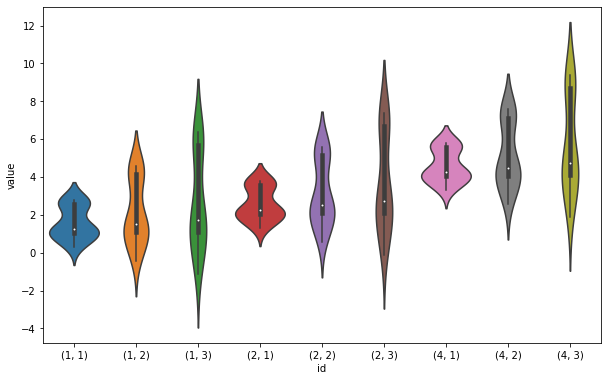

In [9]:
# Add an id field concatenating the two relevant levels of the index:
df["id"]=df.reset_index(["mean", "sigma"]).apply(lambda x: "(%s, %s)"%(x["mean"],x["sigma"]), axis=1).values

plt.figure(figsize=(10, 10 / 1.618))
sns.violinplot(
    data=df,
    x="id",
    y="value",
)
# plt.ylim(0.8, 1.1)
plt.show()

In [10]:
# Produce a table summarizing the mean values with its error
df_agg_mean(df.drop(["_run_start", "id"], axis=1), ["mean", "sigma"])

_elapsed_seconds        value
mean sigma                                      
1    1          0.000027 ± 0.000002  1.58 ± 0.19
     2        0.0000218 ± 0.0000002    2.2 ± 0.4
     3        0.0000232 ± 0.0000010    2.7 ± 0.6
2    1      0.00002190 ± 0.00000014  2.58 ± 0.19
     2        0.0000201 ± 0.0000011    3.2 ± 0.4
     3      0.00001280 ± 0.00000009    3.7 ± 0.6
4    1      0.00001280 ± 0.00000009  4.58 ± 0.19
     2      0.00001260 ± 0.00000011    5.2 ± 0.4
     3        0.0000135 ± 0.0000004    5.7 ± 0.6

## Loading from a module and execution modes

The best practice is to define the experiment in a module

In [11]:
import demo

In this example we include a delay in the function to understand the execution modes

In [12]:
import inspect
print(inspect.getsource(demo.experiment.f))

def experiment_f(mean, sigma, seed):
    # All seeds should be initialized using a parameter for reproducibility
    random.seed(seed)
    # Delay for test purpose
    sleep(mean/100)
    # Return a dict with the results (must be pickleable)
    return {"value": random.normal(mean, sigma)}



### Sequential execution

The default mode is sequential execution (all trials are executed one by one).

Advantages:
- All memory/cpu resources available 
- Execution time is not affected by other processes

Disadvantages:
- Longest execution time

In [13]:
demo.experiment.invalidate()

In [14]:
%%time
demo.experiment.run_all()

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 207 ms, sys: 43.9 ms, total: 251 ms
Wall time: 4.45 s


In [15]:
sum(demo.experiment.get_results_df()["_elapsed_seconds"])

4.251450999999999

### Multithreading execution 

In multithreading execution a pool of threads run the trials.

Advantages:
- If n threads are used and the trial uses only one thread, you can expect a factor of n speed-up, assumming your resources are not exhausted.
- Does not require additional libraries.

Disadvantages:
- Memory consumption increases
- Concurrent execution might affect computation time
- Only one machine can be used still.

In [16]:
demo.experiment.invalidate()

In this example we use 4 threads for a ~4x speed-up:

In [17]:
%%time
demo.experiment.run_all(method="multithreading", threads=4)

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 129 ms, sys: 46.1 ms, total: 175 ms
Wall time: 1.16 s


However, elapsed time is independent for each trial, so the total is approximately the same

In [18]:
sum(demo.experiment.get_results_df()["_elapsed_seconds"])

4.239245999999998